# <p style="text-align: center;">Electric Vehicles Based on Washington State Population</p>

   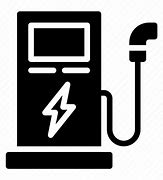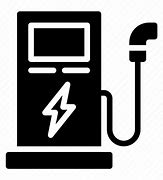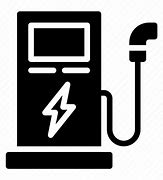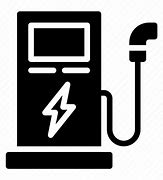

# Setup and Reading in Data


In [9]:

# Dependencies and Setup

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests
import json

from census import Census
from config import api_key
from config import geoapify_key


ModuleNotFoundError: No module named 'config'

## Importing Data and Cleaning

### Adding Census Data

In [8]:
#Load in API Census for the year 2020
c = Census(
    api_key,
    year = 2020
)
#Input Variables
census_data_counties = c.acs5.get(
    ("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E"),
    {'for': 'county:*', 'in': 'state:53'}
)

# Convert the county data to a DataFrame
county_pd = pd.DataFrame(census_data_counties)

# Column renaming
county_pd = county_pd.rename(
    columns={
        "B01003_001E": "Population",
        "B19013_001E": "Household Income",
        "NAME": "County",
        "state": "State Code",
        "county": "County Code"
    }
)
# Remove " County, Washington" from the county names
county_pd["County"] = county_pd["County"].str.replace(" County, Washington", "")



# Configure the final DataFrame
county_pd = county_pd[
    [
        "County",
        "Population",        
        "Household Income",     
              
    ]
]



NameError: name 'api_key' is not defined

### Importing Vehicle CSV

In [3]:
#Load in Electric Vehicle Population csv
wa_data="data/Electric_Vehicle_Population_Data.csv"
#Read csv
wa_df = pd.read_csv(wa_data)

#Setting our Data to only include Washington State
wa_df= wa_df[wa_df['State'] == 'WA']


### Cleaning Data

In [4]:
wa_df.drop(['VIN (1-10)','Postal Code','Base MSRP','Legislative District','DOL Vehicle ID','Vehicle Location','2020 Census Tract'], axis=1, inplace=True)

wa_df = wa_df[wa_df['Electric Range'] !=0]

# Setting a list of Urban Counties in Washington State 
urban_counties = ['Clark', 'Thurston', 'Pierce', 'King', 'Kitsap', 'Snohomish', 'Whatcom', 'Spokane', 'Benton']

# Function to determine the type based on the county
def determine_type(county):
    if county in urban_counties:
        return 'Urban'
    else:
        return 'Rural'

# Adding the 'Type' column to the DataFrame
wa_df.insert(1, 'County Type', wa_df['County'].apply(determine_type))

In [5]:
#Merging both Data Frames
vehicle_census = pd.merge(county_pd, wa_df)
#Viewing New merged Data Frame
vehicle_census

NameError: name 'county_pd' is not defined

# Exploratory Anaylsis

## Hypothesis 1: Do newer vehicles have a further range?

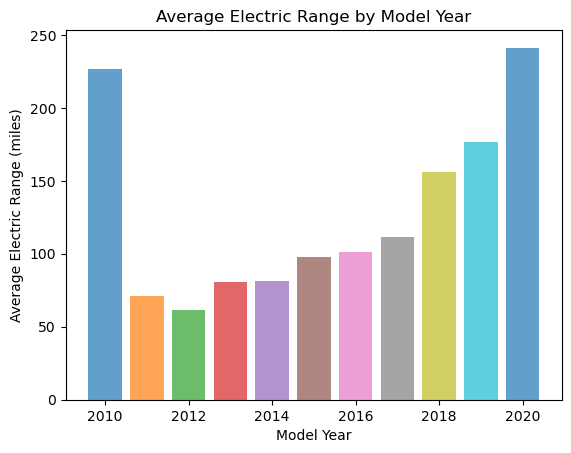

In [16]:
# Filter out rows with missing 'Electric Range' values and limit to 2010-2020 Model Years
vehicle_census_filtered = vehicle_census.dropna(subset=['Electric Range'])
vehicle_census_filtered['Model Year'] = pd.to_numeric(vehicle_census_filtered['Model Year'])
vehicle_census_filtered = vehicle_census_filtered[(vehicle_census_filtered['Model Year'] >= 2010) & (vehicle_census_filtered['Model Year'] <= 2020)]

# Group the data by 'Model Year' and calculate the average 'Electric Range' for each year
average_electric_range_by_year = vehicle_census_filtered.groupby('Model Year')['Electric Range'].mean().reset_index()

# Sort the DataFrame by 'Model Year' in ascending order
average_electric_range_by_year = average_electric_range_by_year.sort_values(by='Model Year')
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

# Plot the bar graph
plt.bar(average_electric_range_by_year['Model Year'], average_electric_range_by_year['Electric Range'], color=colors, alpha=0.7)

# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')

# Set the title
plt.title('Average Electric Range by Model Year')

# Show the plot
plt.show()

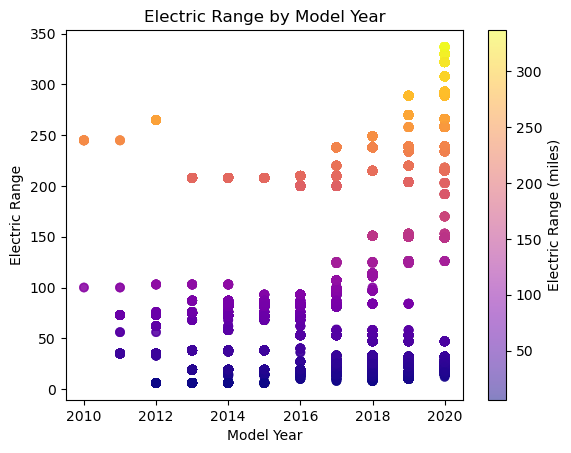

In [19]:
#Electric Range by Model Year

# Set the color for the scatter plot
colors = plt.colormaps.get_cmap('plasma')  

# Plot the scatter plot
plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'],  c=vehicle_census_filtered['Electric Range'], cmap=colors, alpha=0.5)
plt.colorbar(label='Electric Range (miles)')
# Set the x-axis and y-axis labels
plt.xlabel('Model Year')
plt.ylabel('Electric Range')

# Set the title
plt.title('Electric Range by Model Year')

# Show the plot
plt.show()
# Assuming you have the 'vehicle_census' DataFrame with the necessary data

The correlation between Model Year and Electric Range is: 0.51
Linear Regression Analysis:
Slope: 21.375898193409686
Intercept: -42972.690939084794
R-value: 0.5105257012807282
P-value: 0.0
R-squared value: 0.26063649166817926


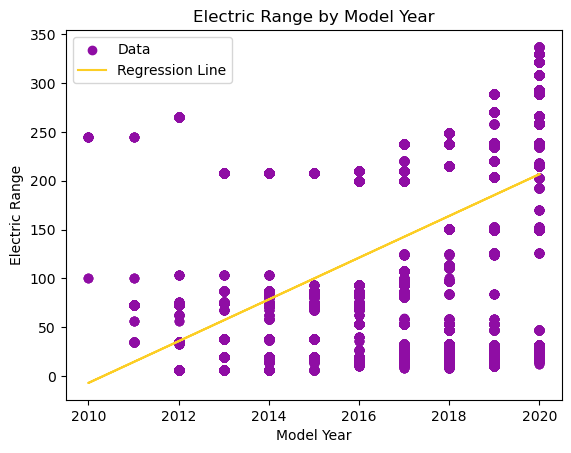

In [20]:
#Check Correlation of Model Year and Range

# Check if 'Model Year' column has varying values
if len(vehicle_census_filtered['Model Year'].unique()) == 1:
    print("Error: 'Model Year' column has constant values. Cannot perform linear regression.")
else:

    # Perform linear regression
    slope, intercept, rvalue, pvalue, _ = st.linregress(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])
    # Create the regression line data
    regression_line = slope * vehicle_census_filtered['Model Year'] + intercept
    # Calculate R-squared value
    r_squared = rvalue ** 2
        # Calculate the correlation coefficient
    correlation_coef, _ = st.pearsonr(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'])
    print("The correlation between Model Year and Electric Range is: {:.2f}".format(correlation_coef))
    print("Linear Regression Analysis:")
    print("Slope:", slope)
    print("Intercept:", intercept)
    print("R-value:", rvalue)
    print("P-value:", pvalue)
    print("R-squared value:", r_squared)
#Set the color for the scatter plot and regression line
    cmap = plt.get_cmap('plasma')  # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma', etc.)

    # Plot the scatter plot with regression line
    plt.scatter(vehicle_census_filtered['Model Year'], vehicle_census_filtered['Electric Range'], color=cmap(0.3), label='Data')
    plt.plot(vehicle_census_filtered['Model Year'], regression_line, color=cmap(0.9), label='Regression Line')

    # Set the x-axis and y-axis labels
    plt.xlabel('Model Year')
    plt.ylabel('Electric Range')

    # Set the title
    plt.title('Electric Range by Model Year')

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

## Purchasing Trends: What is the most popular make and model? Has this changed over time?

In [1]:
#Making new column to hold the values of what type of vehicles that were purchased in Washington for each year
make_df = vehicle_census_filtered.groupby(['Make','Model Year'])['Make'].count().reset_index(name='Count')
#Filtering the data to get a count of the most popular greater than 500
make_df_filtered = make_df[make_df['Count'] >= 500]
make_df_filtered.head()

NameError: name 'vehicle_census_filtered' is not defined

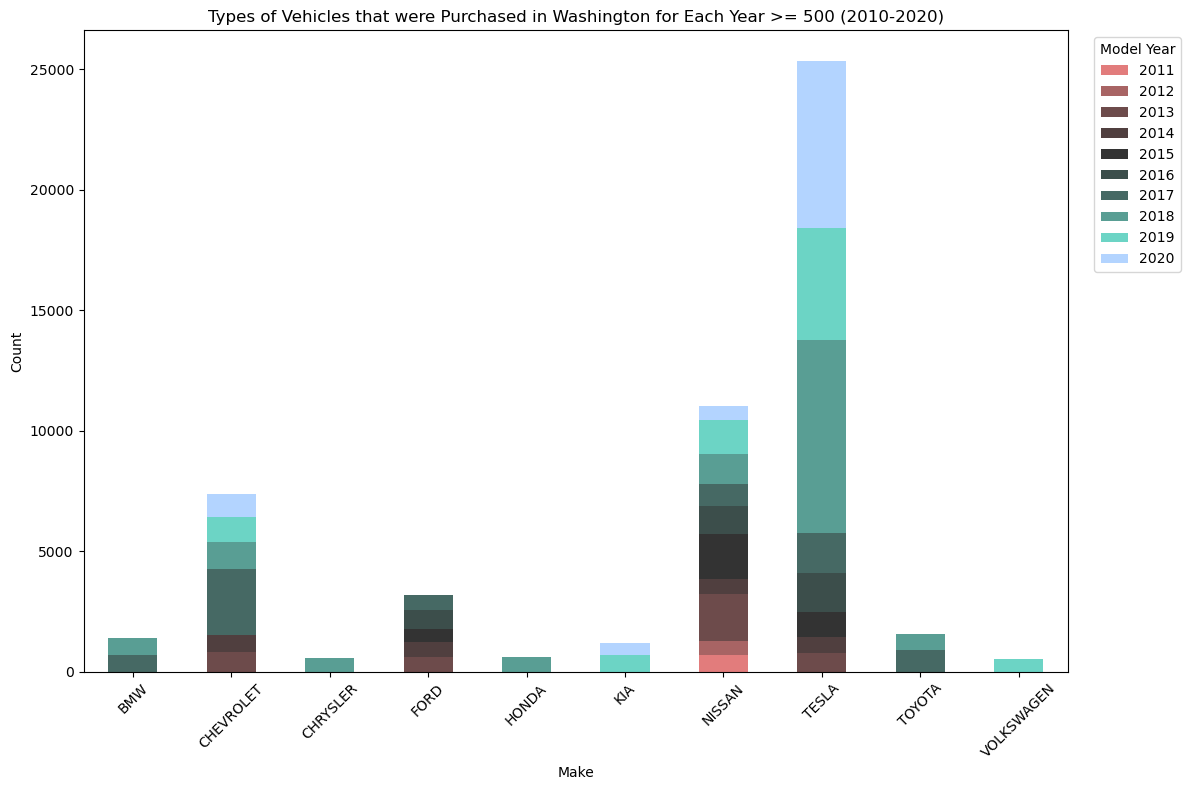

In [18]:
# Pivot the DataFrame to create a stacked bar plot
make_pivot = make_df_filtered.pivot(index='Make', columns='Model Year', values='Count').fillna(0)
#Customize colors
custom_colors = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5","#b3d4ff"]
# Plot the stacked bar chart
make_pivot.plot(kind='bar', stacked=True, figsize=(12, 8),color=custom_colors)
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Types of Vehicles that were Purchased in Washington for Each Year >= 500 (2010-2020)')
plt.legend(title='Model Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rural vs. Urban 

# CHELSEA add geo to show the Rural and Urbanized counties

In [21]:
#Geo for Rural and Urban Counties
#Map of WA Plot the locations color code points (rural one color and urban another color) 
# take centroids (center of counties) then plot based on 
#split the string using the space as the delimeter, 
#iterate through to create lat and long, iterows (index,rows) grab the row and split string 
#plot density of the counties and taking the median and take above urban and rural below


#for i, row in vehicle_cenus_filtered.iterrows():
    #lat_lon_list = row['Vehicle location'].split(" ")
    #row['lat'] = lat_lon_list_[0]
    #row['lon'] =lat_lon_list[1]








# Type of Vehicle by location

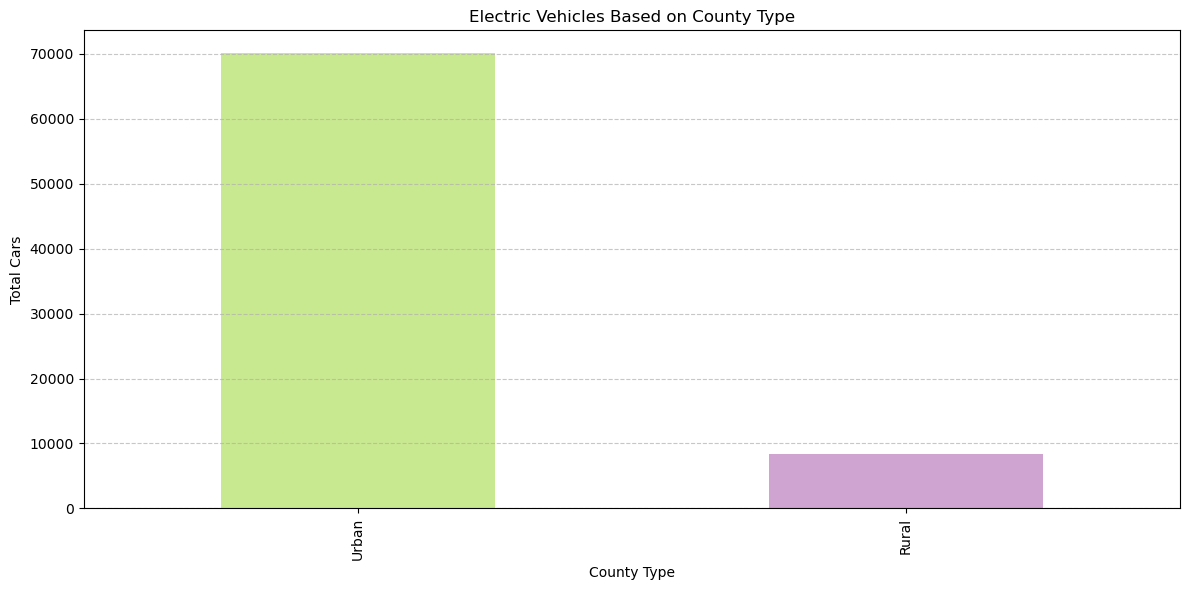

In [22]:
# Group the data by county and calculate the total number of cars in each county
total_cars_by_county = vehicle_census.groupby('County Type')['Make'].count()

# Calculate the correlation between the total cars and electric range for each county
total_cars_by_county = total_cars_by_county.sort_values(ascending=False)
# Plot the bar graph
plt.figure(figsize=(12, 6))
total_cars_by_county.plot(kind='bar', color=["#b2e061", "#bd7ebe"], alpha=0.7)
plt.xlabel('County Type')
plt.ylabel('Total Cars')
plt.title('Electric Vehicles Based on County Type')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:

bev= vehicle_census[vehicle_census['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
phev = vehicle_census[vehicle_census['Electric Vehicle Type'] == 'Plug-in Hybrid Electric Vehicle (PHEV)']


In [24]:
bev_county_type = bev.groupby('County Type').size().reset_index(name='BEV Count')
phev_county_type = phev.groupby('County Type').size().reset_index(name='PHEV Count')
merged_df = pd.merge(bev_county_type, phev_county_type, on='County Type', how='outer')
merged_df

,County Type,BEV Count,PHEV Count
0,Rural,4507,3832
1,Urban,42028,28047


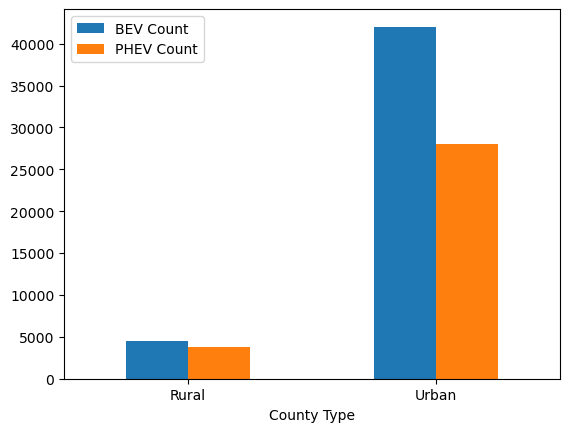

In [28]:
merged_df.plot.bar(x='County Type', rot = 0)
plt.show()

# Analysis